In [62]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [63]:
#load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (5000, 20)
Test shape: (500, 19)


In [64]:
#statistics of the data 
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hospital_Id,5000,5000,fffe3200360030003700,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Supplier_Name,5000,4966,Robert Davis,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Supplier_Reliability,4413.0,NaN,NaN,NaN,0.460925,0.265964,0.0,0.23,0.45,0.67,1.0
Equipment_Height,4717.0,NaN,NaN,NaN,21.759593,11.944434,3.0,12.0,20.0,30.0,73.0
Equipment_Width,4557.0,NaN,NaN,NaN,9.585034,5.407542,2.0,6.0,8.0,12.0,50.0
Equipment_Weight,4540.0,NaN,NaN,NaN,409758.435022,2808639.916146,3.0,507.0,3137.5,36941.5,117927869.0
Equipment_Type,4401,7,Aluminium,655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Equipment_Value,5000.0,NaN,NaN,NaN,1190.293363,8724.804213,3.0,5.26,7.935,87.0475,382385.67
Base_Transport_Fee,5000.0,NaN,NaN,NaN,37.374362,26.907914,10.0,16.63,23.41,57.805,99.98
CrossBorder_Shipping,5000,2,No,3333,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
#check for negatives in training data
numeric_cols=train.select_dtypes('number').columns.tolist()
print("any negative numeric values per column:")
display((train[numeric_cols]<0).any())

any negative numeric values per column:


Supplier_Reliability    False
Equipment_Height        False
Equipment_Width         False
Equipment_Weight        False
Equipment_Value         False
Base_Transport_Fee      False
Transport_Cost           True
dtype: bool

In [66]:
#check for duplicates
dup_count = train.duplicated().sum()
print(f"Number of duplicate rows in train: {dup_count}")

if dup_count > 0:
    train.drop_duplicates(inplace=True)
    print("Duplicates removed. New shape:", train.shape)

Number of duplicate rows in train: 0


In [67]:
#check for missing vals
print("\nMissing Values in Train Dataset:")
print(train.isnull().sum())


Missing Values in Train Dataset:
Hospital_Id                0
Supplier_Name              0
Supplier_Reliability     587
Equipment_Height         283
Equipment_Width          443
Equipment_Weight         460
Equipment_Type           599
Equipment_Value            0
Base_Transport_Fee         0
CrossBorder_Shipping       0
Urgent_Shipping            0
Installation_Service       0
Transport_Method        1071
Fragile_Equipment          0
Hospital_Info              0
Rural_Hospital           586
Order_Placed_Date          0
Delivery_Date              0
Hospital_Location          0
Transport_Cost             0
dtype: int64


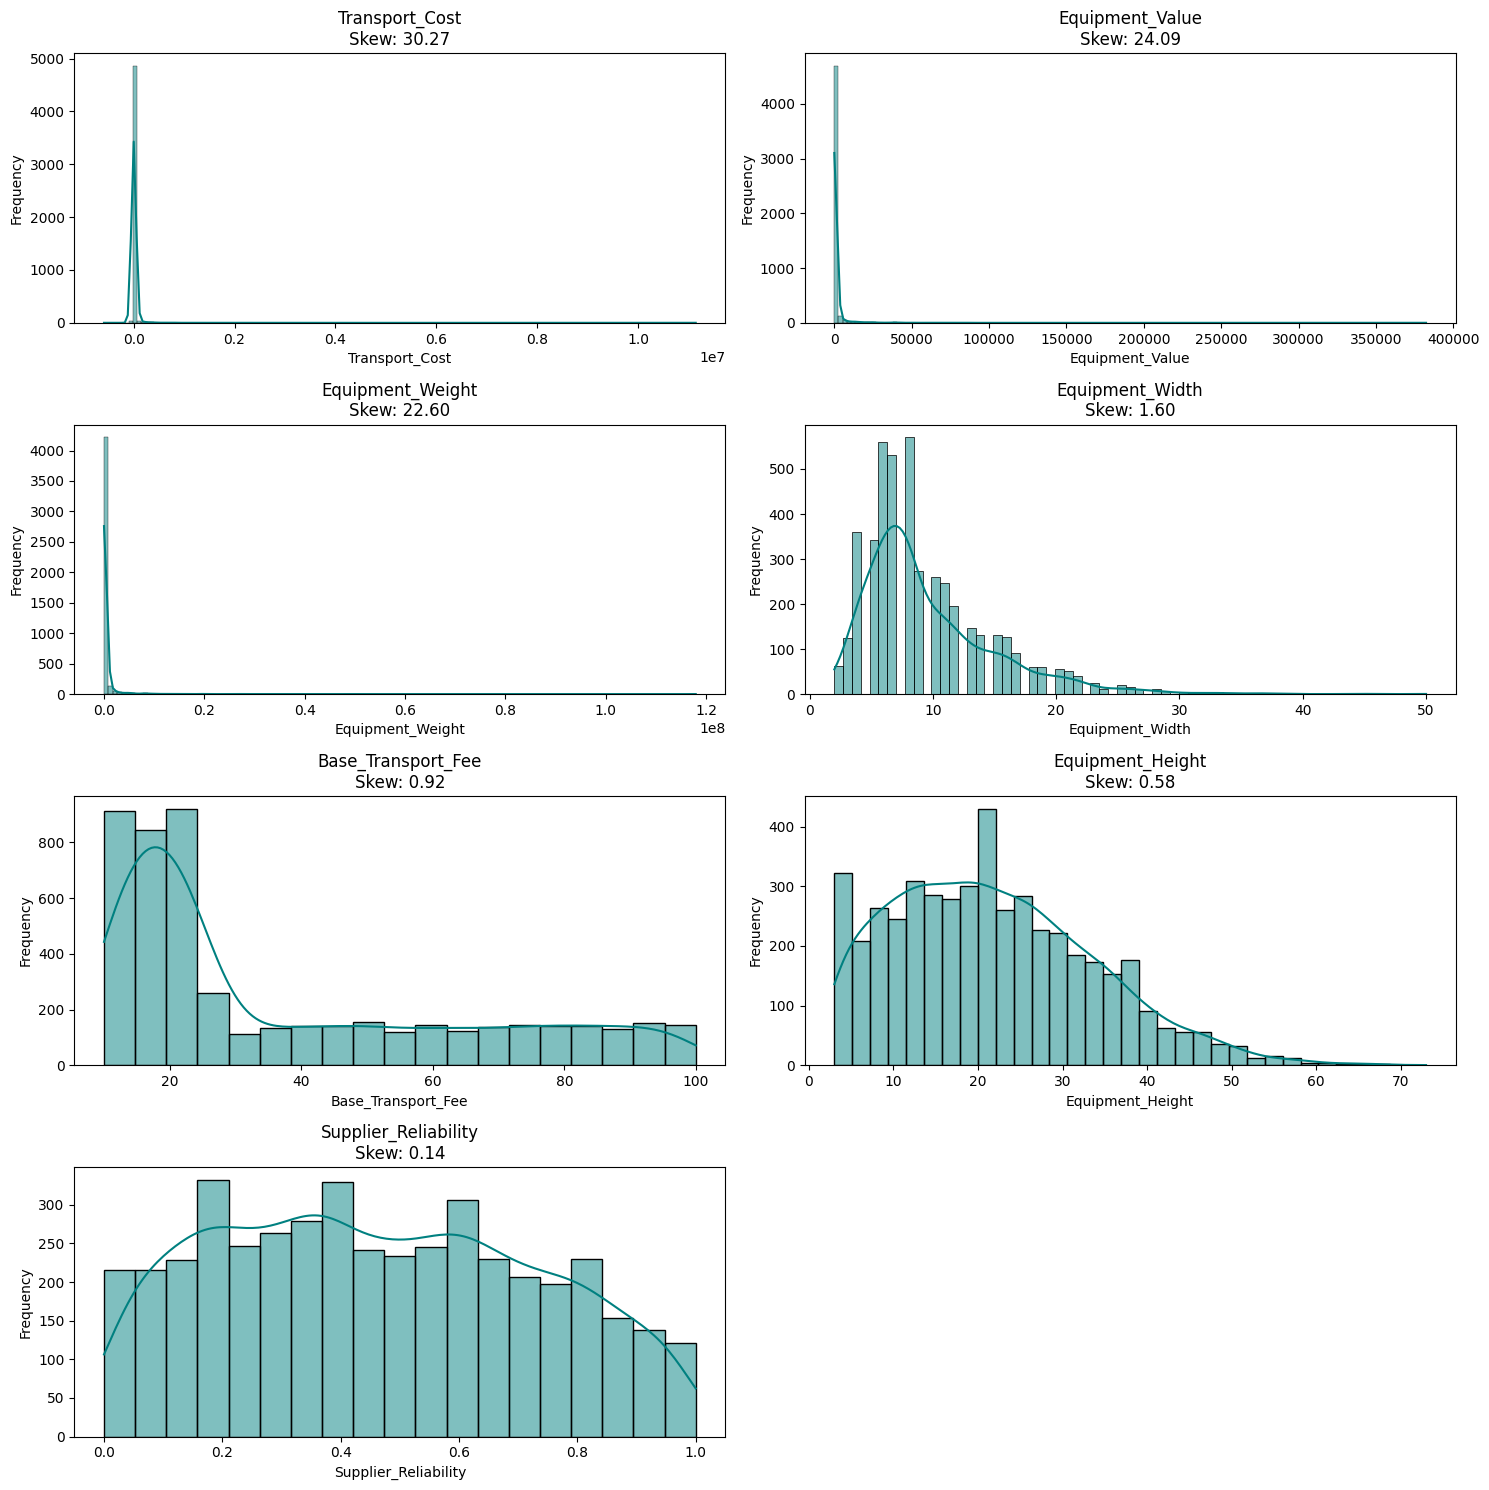

In [68]:
#Feature Distributions for checking how features are spread
num_cols_for_histogram = ['Supplier_Reliability', 'Equipment_Height', 'Equipment_Width',
                          'Equipment_Weight', 'Equipment_Value', 'Base_Transport_Fee','Transport_Cost']

# Sort columns by skewness
skew_values = train[num_cols_for_histogram].skew().sort_values(ascending=False)
sorted_cols = skew_values.index.tolist()

# Plot histograms in skewness order
plt.figure(figsize=(15,15))
for i, col in enumerate(sorted_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(train[col].dropna(), kde=True, bins='auto', color='teal')
    plt.title(f'{col}\nSkew: {skew_values[col]:.2f}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

plt.tight_layout()
plt.show()


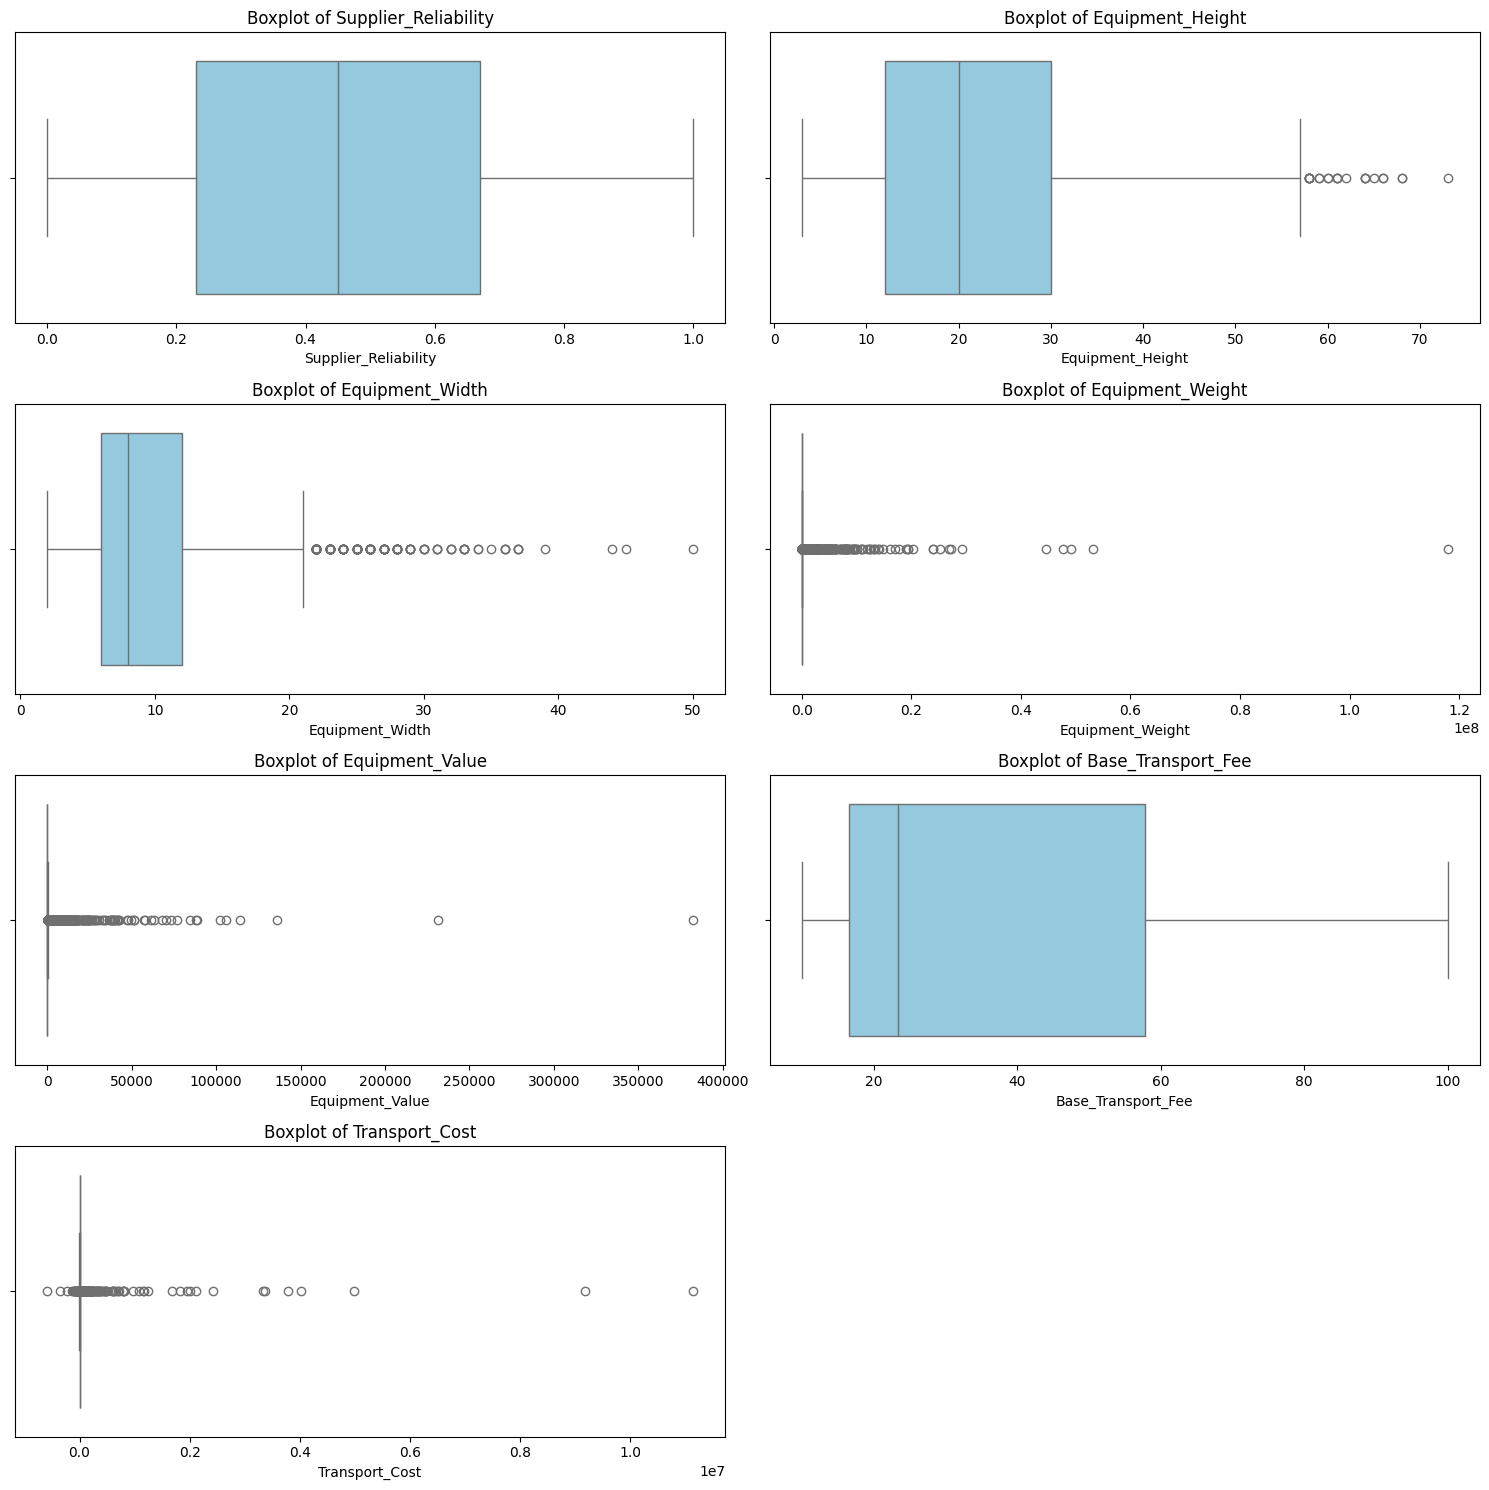

In [69]:
num_cols_for_boxplot = ['Supplier_Reliability', 'Equipment_Height', 'Equipment_Width',
                        'Equipment_Weight', 'Equipment_Value', 'Base_Transport_Fee','Transport_Cost']
#Box plots for Outlier Detection 
plt.figure(figsize=(15, 15))
for i, col in enumerate(num_cols_for_boxplot, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=train, x=col, color='skyblue')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

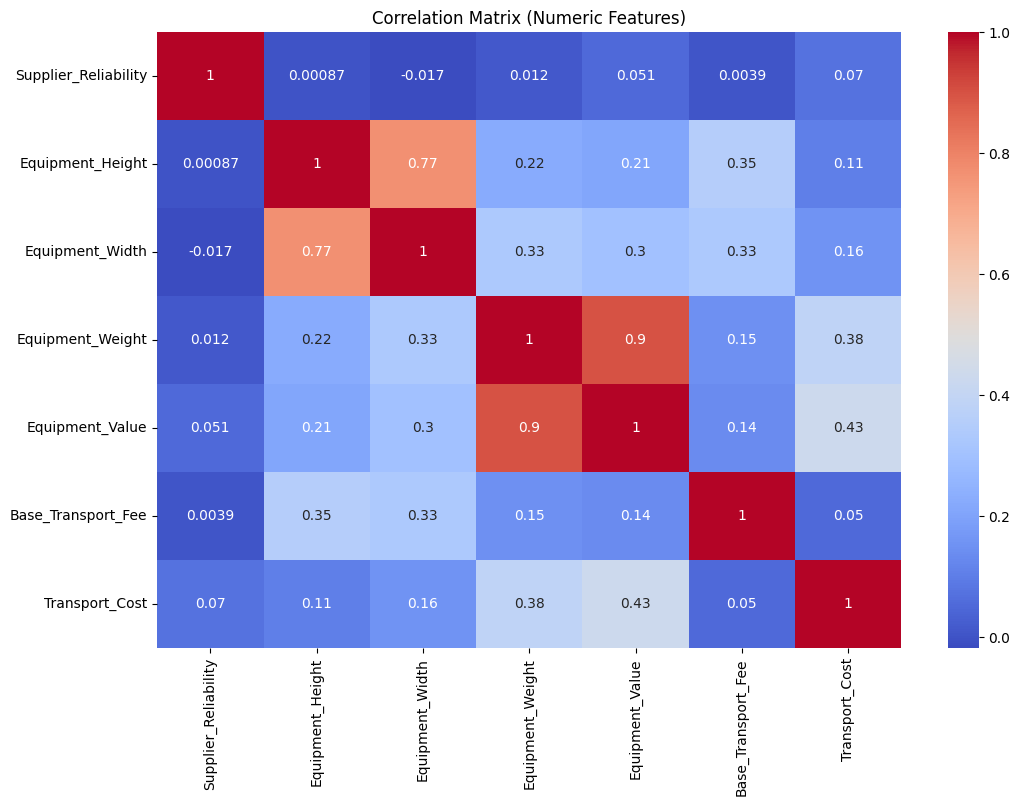

In [70]:
#to find linear relationdships
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12,8))
sns.heatmap(train[numeric_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

In [71]:
# Feature Engineering
def map_binary(series):
    return series.astype(str).str.lower().isin(['yes','y','true','1']).astype(int)

for df in [train, test]:
    # Dates
    df['Order_Placed_Date'] = pd.to_datetime(df['Order_Placed_Date'], errors='coerce')
    df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'], errors='coerce')
    df['Delivery_Lag_Days'] = (df['Delivery_Date'] - df['Order_Placed_Date']).dt.days.clip(lower=0).fillna(0).astype(int)
    df['Order_Day_of_Week'] = df['Order_Placed_Date'].dt.dayofweek.fillna(-1).astype(int)
    df['Order_Month'] = df['Order_Placed_Date'].dt.month.fillna(0).astype(int)
    
    # Equipment
    df['Equipment_Volume'] = df['Equipment_Height'] * df['Equipment_Width'].clip(lower=1e-6)
    df['Equipment_Density'] = df['Equipment_Weight'].clip(lower=1e-6) / df['Equipment_Volume'].clip(lower=1e-6)
    df['Value_per_Weight'] = df['Equipment_Value'] / df['Equipment_Weight'].clip(lower=1e-6)
    df['Fee_per_Weight'] = df['Base_Transport_Fee'] / df['Equipment_Weight'].clip(lower=1e-6)
    
    # Binary columns
    for col in ['CrossBorder_Shipping', 'Urgent_Shipping', 'Installation_Service', 'Fragile_Equipment', 'Rural_Hospital']:
        df[col] = map_binary(df[col])
    
    # Interaction
    df['Urgent_and_Fragile'] = df['Urgent_Shipping'] * df['Fragile_Equipment']

In [72]:
# Rare Category Grouping - Categories with very low frequency in categorical variables were grouped into an "Other" category.
categorical_cols = ['Equipment_Type', 'Transport_Method', 'Hospital_Info']
freq_threshold = 0.01
for col in categorical_cols:
    freq = train[col].value_counts(normalize=True).fillna(0)
    rare_labels = freq[freq<freq_threshold].index
    train[col] = train[col].replace(rare_labels, 'Other')
    test[col] = test[col].apply(lambda x: x if x in train[col].unique() else 'Other')

In [73]:
#  Drop unnecessary columns
cols_to_drop = ['Hospital_Id','Supplier_Name','Hospital_Location','Order_Placed_Date','Delivery_Date']
train.drop(cols_to_drop, axis=1, inplace=True)
test_id = test['Hospital_Id']
test.drop([c for c in cols_to_drop if c != 'Hospital_Id'], axis=1, inplace=True)

In [74]:
# Define Features & Target
numeric_cols = ['Supplier_Reliability','Equipment_Height','Equipment_Width','Equipment_Weight',
                'Equipment_Value','Base_Transport_Fee','Delivery_Lag_Days','Order_Day_of_Week',
                'Order_Month','Equipment_Volume','Equipment_Density','Value_per_Weight','Fee_per_Weight',
                'Urgent_and_Fragile']
binary_cols = ['CrossBorder_Shipping','Urgent_Shipping','Installation_Service','Fragile_Equipment','Rural_Hospital']

#applied log transform on clipped target
y = np.log(train['Transport_Cost'].clip(lower=1))
X = train.drop('Transport_Cost', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [75]:
from sklearn.base import BaseEstimator, TransformerMixin

# Outlier Clipper
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, clip_cols, lower_q=0.01, upper_q=0.99):
        self.clip_cols = clip_cols
        self.lower_q = lower_q
        self.upper_q = upper_q
        self.lower_bounds = {}
        self.upper_bounds = {}
        
    def fit(self, X, y=None):
        for col in self.clip_cols:
            if col in X.columns:
                self.lower_bounds[col] = X[col].quantile(self.lower_q)
                self.upper_bounds[col] = X[col].quantile(self.upper_q)
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.clip_cols:
            if col in X_copy.columns:
                X_copy[col] = X_copy[col].clip(lower=self.lower_bounds[col], upper=self.upper_bounds[col])
        return X_copy

cols_to_clip = ['Equipment_Value','Base_Transport_Fee','Equipment_Height','Equipment_Width',
                'Equipment_Weight','Equipment_Density','Value_per_Weight','Fee_per_Weight','Delivery_Lag_Days']


In [76]:
#  Preprocessing Pipelines - Instead of manually applying each step, you wrap them together into one object.
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clipper', OutlierClipper(cols_to_clip)),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

full_preproc = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
    ('cat', cat_pipe, categorical_cols)
], remainder='passthrough', verbose_feature_names_out=False)

In [77]:
print("\n Final Training Columns:", list(X_train.columns))
print("\n Preprocessing Complete!")


 Final Training Columns: ['Supplier_Reliability', 'Equipment_Height', 'Equipment_Width', 'Equipment_Weight', 'Equipment_Type', 'Equipment_Value', 'Base_Transport_Fee', 'CrossBorder_Shipping', 'Urgent_Shipping', 'Installation_Service', 'Transport_Method', 'Fragile_Equipment', 'Hospital_Info', 'Rural_Hospital', 'Delivery_Lag_Days', 'Order_Day_of_Week', 'Order_Month', 'Equipment_Volume', 'Equipment_Density', 'Value_per_Weight', 'Fee_per_Weight', 'Urgent_and_Fragile']

 Preprocessing Complete!
